### Goal
In my previous practice, I forecasted electricity demand using the Prophet model based on historical electricity demand only. In this code, I treat electricity demand forecasting as a regression problem that considers multiple factors, including temperature, and quantify the importance of features using the random forest approach.

This is a supervised machine learning problem because there are both the features and the targets (electricity demand) that I want to predict.

### Basics About Random Forest Models
A random forest model can be used for both classification and regression by considering non-linear factors. Briefly, a random forest model is based on multiple decision trees. Each tree finds decision-making rules in parallel based on a dataset created by randomly sampling with replacement of the original dataset (i.e., bootstrapping). The forecast is derived from the average of predictions by all decision trees.

In addition to random sampling of the dataset, the model determines the number of features that are randomly sampled. The importance of features is based on how much each feature decreases impurity, which describes the level of predictivity. Higher impurity indicates more mixed data, making prediction harder. A similar approach is gradient boosting models, but they run decision trees in sequence to reduce biases in the previous trees.

### Steps of This Code
1. Download hourly electricity demand and weather data for different countries in Europe from the Open Power System Data (https://open-power-system-data.org/). For simplicity, I chose Austria as an example.
2. Merge the electricity demand data with weather data by time.
3. Consider several features, including hour, day of the week, day of the month, month, and temperature, to run the random forest model.
4. Evaluate the model by calculating the mean absolute error and then use it to calculate accuracy.
5. Plot actual and forecasted demand and importance of each feature.

In [ ]:
# load libraries
import pandas as pd  # for data manipulation
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [ ]:
# Load energy demand dataset with hourly data
energy_data_url = 'https://data.open-power-system-data.org/time_series/2020-10-06/time_series_60min_singleindex.csv'
energy_data = pd.read_csv(energy_data_url)
print(energy_data.head())

          utc_timestamp        cet_cest_timestamp  \
0  2014-12-31T23:00:00Z  2015-01-01T00:00:00+0100   
1  2015-01-01T00:00:00Z  2015-01-01T01:00:00+0100   
2  2015-01-01T01:00:00Z  2015-01-01T02:00:00+0100   
3  2015-01-01T02:00:00Z  2015-01-01T03:00:00+0100   
4  2015-01-01T03:00:00Z  2015-01-01T04:00:00+0100   

   AT_load_actual_entsoe_transparency  AT_load_forecast_entsoe_transparency  \
0                                 NaN                                   NaN   
1                              5946.0                                6701.0   
2                              5726.0                                6593.0   
3                              5347.0                                6482.0   
4                              5249.0                                6454.0   

   AT_price_day_ahead  AT_solar_generation_actual  \
0                 NaN                         NaN   
1                35.0                         NaN   
2                45.0                         N

In [ ]:
# use Austria as an example
AT_energy_data = energy_data[['utc_timestamp', 'AT_load_actual_entsoe_transparency']]

# time format
AT_energy_data['utc'] = pd.to_datetime(AT_energy_data['utc_timestamp'])
print(AT_energy_data.tail())

              utc_timestamp  AT_load_actual_entsoe_transparency  \
50396  2020-09-30T19:00:00Z                              6661.0   
50397  2020-09-30T20:00:00Z                              6336.0   
50398  2020-09-30T21:00:00Z                              5932.0   
50399  2020-09-30T22:00:00Z                              5628.0   
50400  2020-09-30T23:00:00Z                              5395.0   

                            utc  
50396 2020-09-30 19:00:00+00:00  
50397 2020-09-30 20:00:00+00:00  
50398 2020-09-30 21:00:00+00:00  
50399 2020-09-30 22:00:00+00:00  
50400 2020-09-30 23:00:00+00:00  


<ipython-input-3-15a366825490>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AT_energy_data['utc'] = pd.to_datetime(AT_energy_data['utc_timestamp'])


In [ ]:
# Load your weather dataset with hourly data
weather_data_url = 'https://data.open-power-system-data.org/weather_data/2020-09-16/weather_data.csv'
weather_data = pd.read_csv(weather_data_url)  # replace with your file path
print(weather_data.head())

AT_weather_data = weather_data[['utc_timestamp', 'AT_temperature']]
AT_weather_data['utc'] = pd.to_datetime(AT_weather_data['utc_timestamp'])
print(AT_weather_data.tail())

          utc_timestamp  AT_temperature  AT_radiation_direct_horizontal  \
0  1980-01-01T00:00:00Z          -3.640                             0.0   
1  1980-01-01T01:00:00Z          -3.803                             0.0   
2  1980-01-01T02:00:00Z          -3.969                             0.0   
3  1980-01-01T03:00:00Z          -4.076                             0.0   
4  1980-01-01T04:00:00Z          -4.248                             0.0   

   AT_radiation_diffuse_horizontal  BE_temperature  \
0                              0.0          -0.720   
1                              0.0          -1.165   
2                              0.0          -1.434   
3                              0.0          -1.843   
4                              0.0          -2.094   

   BE_radiation_direct_horizontal  BE_radiation_diffuse_horizontal  \
0                             0.0                              0.0   
1                             0.0                              0.0   
2             

<ipython-input-4-6d7445b6fb6a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AT_weather_data['utc'] = pd.to_datetime(AT_weather_data['utc_timestamp'])


In [ ]:
# Merge datasets on time
AT_data = pd.merge(AT_energy_data, AT_weather_data, on='utc')
print(AT_data.head())
print(AT_data.tail())

        utc_timestamp_x  AT_load_actual_entsoe_transparency  \
0  2014-12-31T23:00:00Z                                 NaN   
1  2015-01-01T00:00:00Z                              5946.0   
2  2015-01-01T01:00:00Z                              5726.0   
3  2015-01-01T02:00:00Z                              5347.0   
4  2015-01-01T03:00:00Z                              5249.0   

                        utc       utc_timestamp_y  AT_temperature  
0 2014-12-31 23:00:00+00:00  2014-12-31T23:00:00Z          -6.495  
1 2015-01-01 00:00:00+00:00  2015-01-01T00:00:00Z          -6.503  
2 2015-01-01 01:00:00+00:00  2015-01-01T01:00:00Z          -6.458  
3 2015-01-01 02:00:00+00:00  2015-01-01T02:00:00Z          -6.253  
4 2015-01-01 03:00:00+00:00  2015-01-01T03:00:00Z          -5.908  
            utc_timestamp_x  AT_load_actual_entsoe_transparency  \
43820  2019-12-31T19:00:00Z                              6748.0   
43821  2019-12-31T20:00:00Z                              6429.0   
43822  2019-

In [ ]:
# Feature engineering
AT_data['Hour'] = AT_data['utc'].dt.hour
AT_data['DayOfWeek'] = AT_data['utc'].dt.dayofweek
AT_data['DayOfMonth'] = AT_data['utc'].dt.day
AT_data['Month'] = AT_data['utc'].dt.month
print(AT_data.head())


        utc_timestamp_x  AT_load_actual_entsoe_transparency  \
0  2014-12-31T23:00:00Z                                 NaN   
1  2015-01-01T00:00:00Z                              5946.0   
2  2015-01-01T01:00:00Z                              5726.0   
3  2015-01-01T02:00:00Z                              5347.0   
4  2015-01-01T03:00:00Z                              5249.0   

                        utc       utc_timestamp_y  AT_temperature  Hour  \
0 2014-12-31 23:00:00+00:00  2014-12-31T23:00:00Z          -6.495    23   
1 2015-01-01 00:00:00+00:00  2015-01-01T00:00:00Z          -6.503     0   
2 2015-01-01 01:00:00+00:00  2015-01-01T01:00:00Z          -6.458     1   
3 2015-01-01 02:00:00+00:00  2015-01-01T02:00:00Z          -6.253     2   
4 2015-01-01 03:00:00+00:00  2015-01-01T03:00:00Z          -5.908     3   

   DayOfWeek  DayOfMonth  Month  
0          2          31     12  
1          3           1      1  
2          3           1      1  
3          3           1      1  


In [ ]:
# since # of NaN is very small, drop it
# total_entries = AT_data['AT_temperature'].size
# nan_temp = AT_data['AT_temperature'].isnull().sum()
# nan_energy = AT_data['AT_load_actual_entsoe_transparency'].isnull().sum()
# nan_energy_percent = nan_energy/total_entries*100
# print(nan_energy_percent)
print(AT_data.shape)

# drop rows with NaN to avoid errors in models
AT_data = AT_data.dropna()
print(AT_data.shape)

(43825, 9)
(43824, 9)


In [ ]:
# Define features and target
# features = ['Hour', 'DayOfWeek', 'DayOfMonth', 'Month', 'Temperature', 'Humidity', 'WindSpeed']  # include relevant weather features
# simpler version
features = ['Hour', 'DayOfWeek', 'DayOfMonth', 'Month', 'AT_temperature']
X = AT_data[features]
y = AT_data['AT_load_actual_entsoe_transparency']

# Split the data, set random_state = 42 for reproducing results, any integer number can work
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model with 100 decision trees
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")
accuracy_percent = (1 - (mae/y_test.mean()))*100
print(f'Accuracy:{accuracy_percent:.2f}%')

Mean Squared Error: 115366.60926681115
Mean Absolute Error: 214.00283171705647
Accuracy:96.99%


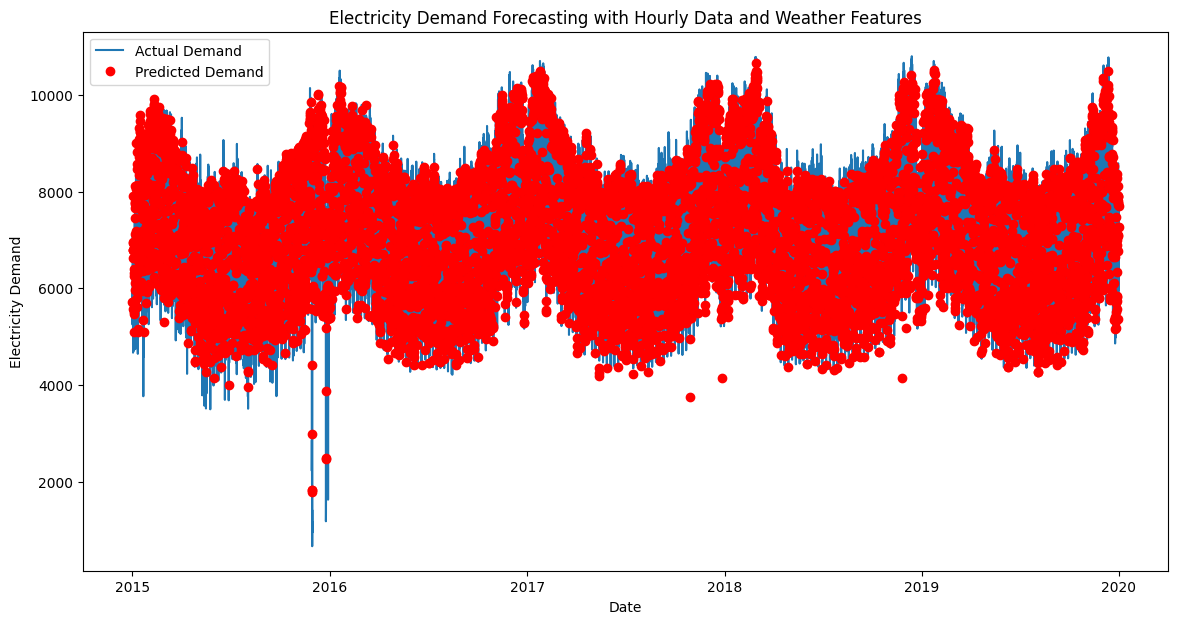

(8765,)


In [ ]:
# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(AT_data['utc'], AT_data['AT_load_actual_entsoe_transparency'], label='Actual Demand')
plt.plot(AT_data['utc'].iloc[y_test.index], y_pred, 'ro', label='Predicted Demand')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Electricity Demand')
plt.title('Electricity Demand Forecasting with Hourly Data and Weather Features')
plt.show()

print(y_pred.shape)

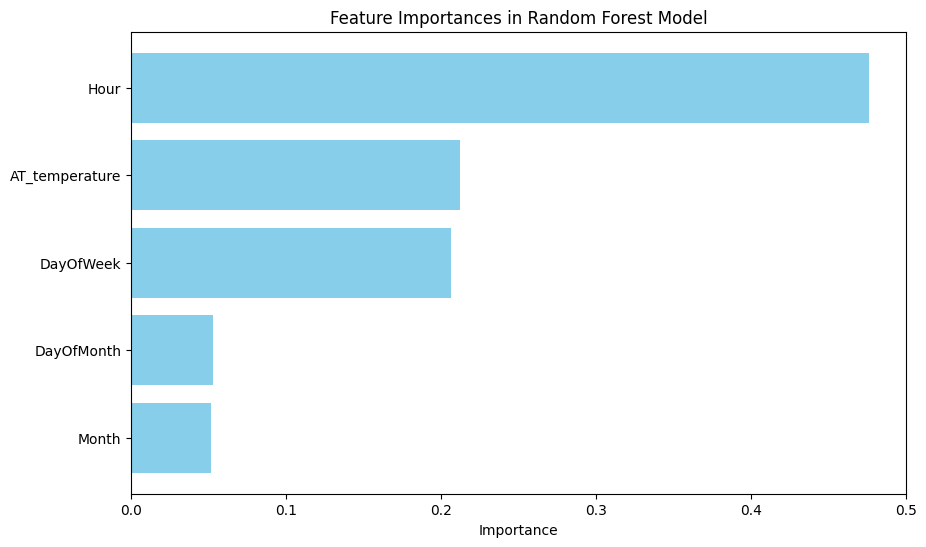

In [ ]:
# Extract feature importances
feature_importances = model.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sort the features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances in Random Forest Model')
plt.gca().invert_yaxis()
plt.show()


The accuracy of the model is almost 97%, and the actual demand and forecasted demand show consistency.

According to the plot of feature importance, the hour is the most important feature, followed by temperature and the day of the week. The hourly variations are often driven by behavior or occupancy pattners. For example, commercial buildings use electricity during working hours, while residential buildings use electricity in the morning and evening after going home. The day of the week is important, as electricity demand during workdays is typically higher than demand during weekends. The importance of months is low, which may indicate that seasonality is explained through temperature.

This notebook demonstrates how to apply a random forest model to forecast electricity demand and analyze feature importance, providing insights into which factors most significantly impact the predictions.


In [ ]:
# !pip install --upgrade scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 60.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


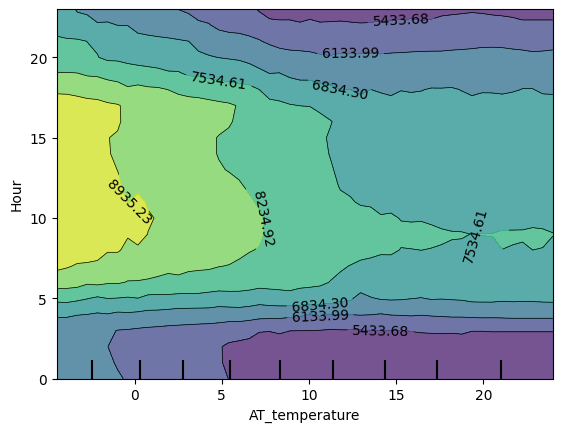

In [ ]:
## investigate partial dependence
# from sklearn.inspection import PartialDependenceDisplay

## Plot partial dependence for the interaction of two features
# features_to_plot = [('AT_temperature', 'Hour')]
# PartialDependenceDisplay.from_estimator(model, X_train, features_to_plot, grid_resolution=50)
# plt.show()
